<a href="https://colab.research.google.com/github/AkiraMJ/-MEC-502_Topicos_MecSol-/blob/main/Atividade_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade EA3 - Edson Akira Minatogawa Junior

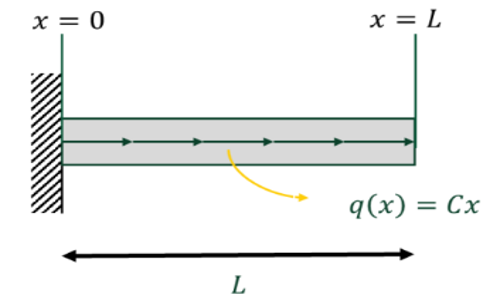

In [ ]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1Bs6lJyQLNlDm9EaSWyMrgHGdD-0A_M3i'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (500, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1Bs6lJyQLNlDm9EaSWyMrgHGdD-0A_M3i/view?usp=drive_link

Para uma barra linear estática, podemos definir o problema de mecânica da estruturas conforme o seguinte sistema.

$$\begin{aligned}
\frac{d}{dx}\left(EA \frac{du}{dx} \right)+ Cx & = 0 & \hspace{1.5cm} \text{em} \ \Omega\\
u & = g  &\hspace{1.5cm} \text{em} \ \Gamma_D
\end{aligned}
$$
Em que se define
* A condição de Dirichlet ($\Gamma_D$)
* $g$ são os deslocamentos em $\Gamma_D$
* $E$ e $A$ são o **Módulo de Elasticidade** e a **Área da barra** e podem variar com $x$

## Obtenção da Solução Analítica

A viga engastada com carga axial é governada pela equação da elasticidade unidimensional, e pode ser expressa por:

$$EA \frac{d^2u}{dx^2} + Cx = 0$$

Onde o carregamento considerado positivo para a direita no mesmo sentido do eixo x.

Sendo uma equação diferencial de segunda ordem, ela exige duas condições para a resolução.

Para resolver a EDO de segunda ordem devemos integrar a equação governante duas vezes.




##Integrações

##Primeira Integração:
Dividindo ambos os lados por EA e integrando em x temos como resultado:
$$\frac{du}{dx} = -\frac{C}{2EA}x^2 + C_1$$

##Segunda Integração:
Obtemos o deslocamento em x:
$$u(x) = -\frac{C}{6EA}x^3 + C_1x + C_2$$

##Aplicando as condições iniciais de contorno:

Condição de contorno para o lado esquerdo da viga $𝑢(0)=0:$

$$u(0) = -\frac{C}{6EA}(0)^3 + C_1(0) + C_2 = 0 \Rightarrow \fbox{$C_2 = 0$}$$


Condição de contorono à  esquerda da viga $u(L) = \frac{3EA}{CL^3}$:

$$u(L) = -\frac{C}{6EA}(L)^3 + C_1 L = \frac{CL^3}{3EA} \Rightarrow 6 C_1 EA L = 3CL^3 \Rightarrow \fbox{$C_1 = \frac{C L^2}{2EA}$}$$

---

Substituindo C1 e C2 na equação do deslocamento u(x), Temos:

$$\fbox{$u(x) = \frac{C}{EA} (\frac{L^2x}{2} -\frac{Cx^3}{6})$}
$$

***Para a resolução deste exercício usarei como solicitado por meio da biblioteca PyTorch, usando como base o exercício exemplo da aula, os códigos serão basicamente copiados, salvo alterações necessárias para o caso em particular, quando as alterações surgirem um bloco novo de código será inserido com as devidas explicações.***

##Função de perda

**Perda de Custo:**

$$\mathcal{L}_{\text{EDO}} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{d}{dx} \left( EA \frac{du_{\theta}}{dx} (x_i) \right) + q(x_i) \right)^2$$

**Perda das condições de contorno:**

$$\mathcal{L}_{\text{Contorno}} = \left( u_{\theta}(0) - 0 \right)^2 + \left( u_{\theta}(L) - \frac{CL^3}{3EA} \right)^2$$

**Perda Total:**

$$\mathcal{L}_{\text{Total}} = \mathcal{L}_{\text{EDO}} + \mathcal{L}_{\text{Contorno}}$$


#Bibliotecas importadas para a solução

In [ ]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
from matplotlib import rc
import numpy as np
dtype = torch.float
device = torch.device("cpu")

In [ ]:
def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""
    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)
    # Reshape on a column tensor and return
    return x.view(samples, 1)

In [ ]:
def get_derivative(y, x, n):
    """Calcula a n-esima deriva de y = f(x) com respeito a x."""
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)

In [ ]:
def build_model(input_dimension, hidden_dimension, output_dimension):
    """Construção da rede neural de dimensões fornecidas."""

    modules=[]
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh())
    for i in range(len(hidden_dimension)-1):
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(torch.nn.Tanh())

    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))

    model = torch.nn.Sequential(*modules)

    return model

In [ ]:
class PhysicsInformedBarModel:
    """A class used for the definition of Physics Informed Models for one dimensional bars."""

    def __init__(self, E, A, L, u0, dist_load):
        """Construct a PhysicsInformedBar model"""

        self.E = E                                      # Modulo de Elasticidade
        self.A = A                                      # Area da barra
        self.L = L                                      # Comprimento da barra
        self.x = generate_grid_1d(L)                    # Pontos de colocacao
        self.u0 = u0                                    # Condicoes de contorno
        self.dist_load = dist_load                      # Carregamento na barra
        self.model = build_model(1,[40],1)              # Definindo a estrutura da rede
        self.EDP_loss_history = None                    # Historico da Funcao de Perda da EDO
        self.ICBC_loss_history = None                   # Historico da Funcao de Perda das Condicoes de Contorno
        self.total_loss_history = None                  # Historico da Funcao de Perda Total
        self.optimizer = None                           # Otimizador


    def get_displacements(self, x):
        """Get displacements."""
        u = self.model(x)   # predict
        return u

    def costFunction(self, x, u_pred):
        """Compute the cost function."""
        # Differential equation loss
        EDP = get_derivative(self.E(x) * self.A(x) * get_derivative(u_pred, x, 1), x, 1) + self.dist_load(x)
        EDP_loss = torch.sum(EDP ** 2).view(1)

        # Boundary condition loss initialization
        ICBC_loss = 0

        # Sum over dirichlet boundary condition losses
        ICBC_loss += (u_pred[0] - self.u0[0]) ** 2
        ICBC_loss += (u_pred[-1] - self.u0[1]) ** 2

        return EDP_loss, ICBC_loss

    def closure(self):

        """Calculation of training error and gradient"""
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x)
        loss = self.costFunction(self.x, u_pred)
        loss = loss[0] + loss[1]
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, print_every, optimizer='Adam', **kwargs):
        """Train the model."""

        # Set optimizer
        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)

        elif optimizer=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

        # Initialize history arrays
        self.PDE_loss_history = np.zeros(epochs)
        self.ICBC_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)

        # Training loop
        for i in range(epochs):
            # Predict displacements
            u_pred = self.get_displacements(self.x)

            # Cost function calculation
            PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred)

            # Total loss
            total_loss = PDE_loss + ICBC_loss

            # Add energy values to history
            self.PDE_loss_history[i] += PDE_loss
            self.ICBC_loss_history[i] += ICBC_loss
            self.total_loss_history[i] += total_loss

            # Print training state
            self.print_training_state(i, epochs, print_every)

            # Update parameters
            self.optimizer.step(self.closure)

    def print_training_state(self, epoch, epochs, print_every):
        """Print the loss values of the current epoch in a training loop."""

        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            # Prepare string
            string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"

            # Format string and print
            print(string.format(epoch, epochs - 1, self.PDE_loss_history[epoch],
                                self.ICBC_loss_history[epoch], self.total_loss_history[epoch]))

    def plot_training_history(self, yscale='log'):
        """Plot the training history."""

        # Set up plot
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Historico da Função de Custo")
        ax.set_xlabel("Epocas")
        ax.set_ylabel("Funcao de Custo")
        plt.yscale(yscale)

        # Plot data
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total")
        ax.plot(self.PDE_loss_history, color='silver', linestyle='--', linewidth=2, label="DE loss")
        ax.plot(self.ICBC_loss_history, color='r', linestyle='-.', linewidth=2, label="BC loss")
        ax.legend()
        fig.tight_layout()
        plt.show()

#Solução por PINN

In [ ]:
# Problem data
E = lambda x: 1
A = lambda x: 1
L =  5
C =  10
#uL_exact = (C * L**3) / (3 * E(torch.tensor([[L]])) * A(torch.tensor([[L]])))
uL_exact = (C * L**3) / (3 * E(L) * A(L))
u0 = [0.0, uL_exact]
distLoad = lambda x: C*x

# Gerando o modelo
pinnModel = PhysicsInformedBarModel(E, A, L, u0, dist_load=distLoad)

###### Treinando o modelo com ADAM
# print("Adam")
# epochs = 1000
# print_every =70  # numero relacionado a quantidade de prints
# learningRate = 1e-5
# pinnModel.train(epochs, print_every, optimizer='Adam', lr=learningRate)

###########################################
###### Treinando o modelo com LBFGS
print("LBFGS")
epochs = 400
print_every =30      # numero relacionado a quantidade de prints
learningRate = 0.01
pinnModel.train(epochs, print_every, optimizer='LBFGS', lr=learningRate)



LBFGS
Epoch: 0/399		Differential equation loss = 17153.486328		Boundary condition loss = 173718.453125		Total loss = 190871.937500
Epoch: 30/399		Differential equation loss = 155.589951		Boundary condition loss = 5.853714		Total loss = 161.443665
Epoch: 60/399		Differential equation loss = 0.752680		Boundary condition loss = 0.000612		Total loss = 0.753293
Epoch: 90/399		Differential equation loss = 0.094768		Boundary condition loss = 0.001290		Total loss = 0.096057
Epoch: 120/399		Differential equation loss = 0.042247		Boundary condition loss = 0.000035		Total loss = 0.042282
Epoch: 150/399		Differential equation loss = 0.019998		Boundary condition loss = 0.000014		Total loss = 0.020013
Epoch: 180/399		Differential equation loss = 0.010385		Boundary condition loss = 0.000002		Total loss = 0.010386
Epoch: 210/399		Differential equation loss = 0.008463		Boundary condition loss = 0.000001		Total loss = 0.008464
Epoch: 240/399		Differential equation loss = 0.005018		Boundary condition los

#Gráficos da Resposta Analítica VS PINN


* Um gráfico comparativo entre a solução da PINN e a solução analítica;


* Um gráfico dos valores das funções de perda (PDE, BC e Total) pelo número de épocas.

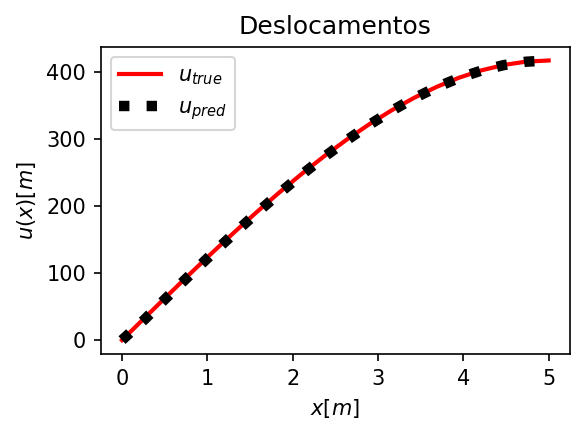

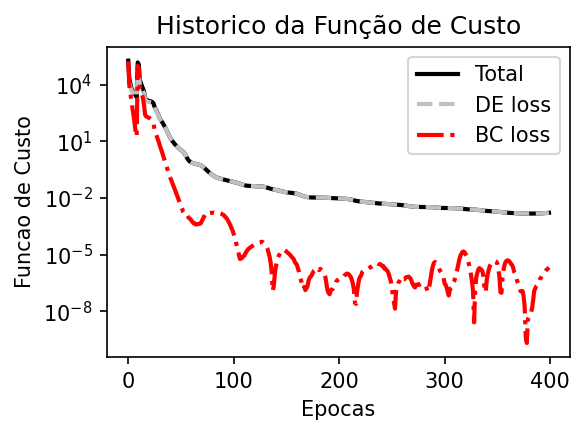

In [ ]:
# Test data
samples = 20
x_test = generate_grid_1d(L, samples)
u_test = pinnModel.get_displacements(x_test)

# Solução Analitica
#u_analytic = lambda x: (C / (E(x) * A(x))) * (((L**2) * x / 2) + ((C * x**3) / 6))
u_analytic = lambda x: (C / (E(x) * A(x)) * ((L**2 * x)/2 - (x**3)/6))

# Plot displacements
plot_displacements_bar(x_test, u_test, u_analytic)

# Plot training history
pinnModel.plot_training_history()

## COMENTÀRIOS

Para um dos cenários anteriores (de preferência que tenha convergido) apresente:

* Qual o otimizador está sendo usado, o número de épocas e a taxa de aprendizado;

***Resposta : Otimizador usado foi o LBFGS, 400 épocas a uma taxa de aprendizado de 0.01***

